In [7]:
#!pip install matplotlib --quiet
#!pip install pandas --quiet
#!pip install xgboost --quiet
#!pip install -U scikit-learn --quiet
#!pip install torch==2.2.0 torchvision==0.17.0 torchaudio==2.2.0 --index-url https://download.pytorch.org/whl/cu121 --quiet
#!pip install optuna --quiet
#!pip install kaggle --quiet

# Hardware 

In [1]:
# Print informatbion abput the GPU and CPU
!nvidia-smi

Wed Apr 17 16:33:35 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.146.02             Driver Version: 535.146.02   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3080 Ti     On  | 00000000:03:00.0 Off |                  N/A |
|  0%   39C    P8              19W / 200W |      1MiB / 12288MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [1]:
from utils import *

# TCN 

__todo__ explain a bit TCN model

# Bayesian Search Finetuning 

check __utils.py__

In [ ]:
import os

study = optuna.create_study(direction='minimize', study_name = "ResidualConvLSTM forecast finetuning")
study.optimize(objective, n_trials=50)

# Results

In [3]:
best_params = study.best_params
best_params

{'input_chunk_length': 512,
 'output_chunk_length': 10,
 'kernel_size': 2,
 'dilation_base': 4,
 'num_layers': 4,
 'num_filters': 4,
 'dropout': 0.5}

/tmp/ipykernel_48281/1055883533.py:4: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  vis.matplotlib.plot_optimization_history(study)


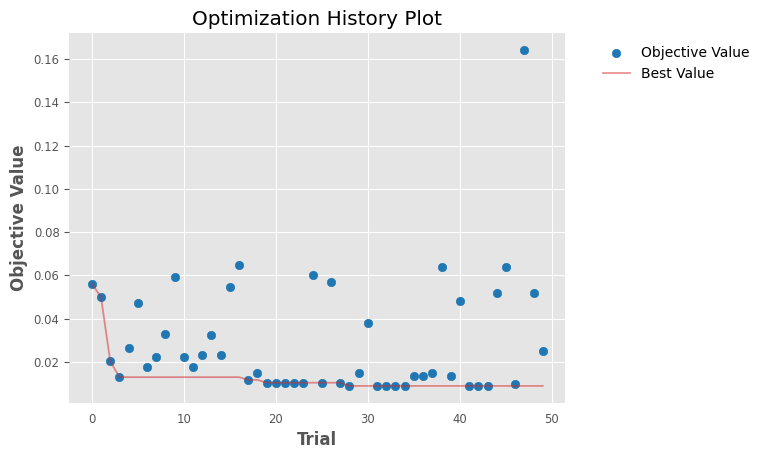

In [5]:
# Plotting Optimization History
import optuna.visualization as vis

vis.matplotlib.plot_optimization_history(study)
plt.show()

/tmp/ipykernel_48281/476168495.py:2: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  vis.matplotlib.plot_param_importances(study)


<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

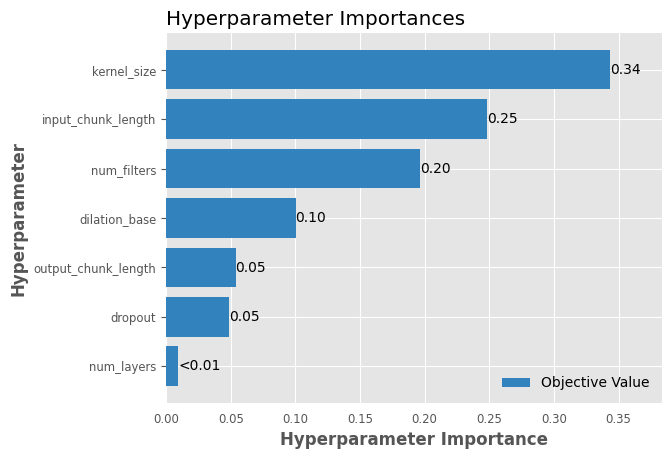

In [6]:
# Plotting Parameter Importance
vis.matplotlib.plot_param_importances(study)


/tmp/ipykernel_48281/2817791742.py:2: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  vis.matplotlib.plot_contour(study, params=["input_chunk_length", "kernel_size"])
[W 2024-04-17 21:07:27,493] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


<Axes: title={'center': 'Contour Plot'}, xlabel='input_chunk_length', ylabel='kernel_size'>

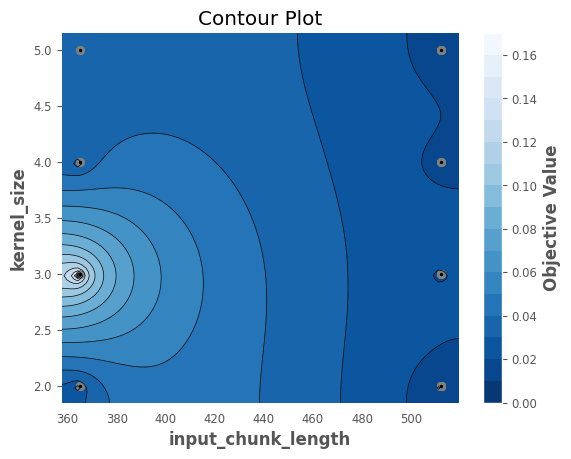

In [9]:
# Plotting a Contour Plot in Optuna
vis.matplotlib.plot_contour(study, params=["input_chunk_length", "kernel_size"])

In [12]:
def forecast(best_params):
    my_stopper = EarlyStopping(
        monitor="val_loss",
        patience=9,
        min_delta=0.0001,
        mode='min',)
    criterion = MeanAbsoluteError()
    pl_trainer_kwargs={"callbacks": [my_stopper]}
    model = TCNModel(
        input_chunk_length=best_params["input_chunk_length"],
        output_chunk_length=best_params["output_chunk_length"],
        n_epochs=n_epochs,
        batch_size = BATCH_SIZE,
        random_state = random_seed,
        optimizer_kwargs = {'lr': learning_rate},
        lr_scheduler_kwargs = {"patience":4} ,
        pl_trainer_kwargs = pl_trainer_kwargs,
        lr_scheduler_cls = ReduceLROnPlateau,
        torch_metrics = criterion,
        kernel_size=best_params["kernel_size"], num_filters=best_params["num_filters"],
        num_layers=2, dilation_base=best_params["dilation_base"], weight_norm=False, dropout=best_params["dropout"],)
    model.fit(train, val_series = val)    
    pred = model.predict(n = 100, series = to_forecast)
    pred = (pred['6'].values() * np.sqrt(y_var)) + y_mean
    return pred

In [ ]:
pred = forecast(study.best_params)

## save prediction

In [16]:
submission = pd.DataFrame(pred, columns=['Prediction'])
submission['Id'] = range(100)
submission = submission[['Id', 'Prediction']]
submission.to_csv('submission.csv', index=False)

In [ ]:
%env KAGGLE_USERNAME= #########
%env KAGGLE_KEY= ##########

In [19]:
!kaggle competitions submit -c time-series-classification-part-2new -f submission.csv -m f"TCN {study.best_params}"

100%|██████████████████████████████████████| 2.14k/2.14k [00:00<00:00, 3.05kB/s]
Successfully submitted to Time Series Classification: Part 2